In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
sheet = pd.read_excel('data_input/PX-WTI价差.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['PX-WTI价差'].last_valid_index()

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=20, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()

,PX-WTI价差,RBOB汽油裂解价差（均价）(预测/2年季节性),美国RBOB汽油裂解(预测/2年季节性),PTA周度产量,PTA总库存超季节性/5Y,PTA加工费/5DMA(预测/最新),山东汽油裂解差
2025-11-18,NaN,23.0476,19.4819,NaN,NaN,92.8822,NaN
2025-11-19,NaN,23.0875,19.6886,NaN,NaN,92.8822,NaN
2025-11-20,NaN,23.2877,19.8603,NaN,NaN,92.8822,NaN
2025-11-21,NaN,23.2034,19.6553,NaN,NaN,92.8822,NaN
2025-11-24,NaN,22.6674,18.9903,NaN,NaN,92.8822,NaN


In [5]:
# 尝试多个可能的文件路径
file_paths1 = [
    os.path.expanduser("~/Desktop/X-BASE/汽柴煤油2.0/eta/山东汽油裂解差_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/汽柴煤油2.0/eta/山东汽油裂解差_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/汽柴煤油2.0/eta/山东汽油裂解差_合并数据.xlsx")
]

file_path1 = None
for path in file_paths1:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path1 = path
        break

if file_path1 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet1 = pd.ExcelFile(file_path1).parse('Sheet1')
    sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
    sheet1 = sheet1.drop(columns=['真实值'])
    sheet1 = sheet1.dropna()
    sheet1 = sheet1.sort_values('Date', ascending=True)
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet1.head()

,Date,预测值
27,2025-05-03,987.5430
26,2025-05-04,1008.4169
25,2025-05-05,1030.9303
24,2025-05-06,1026.7875
23,2025-05-07,1004.2721


In [6]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['山东汽油裂解差'] = sheet_daily['山东汽油裂解差'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

# 将 sheet_daily 重新赋值给 sheet
sheet = sheet_daily.copy()
sheet = sheet.set_index('Date')

In [7]:
sheet.columns

Index(['PX-WTI价差', 'RBOB汽油裂解价差（均价）(预测/2年季节性)', '美国RBOB汽油裂解(预测/2年季节性)',
       'PTA周度产量', 'PTA总库存超季节性/5Y', 'PTA加工费/5DMA(预测/最新)', '山东汽油裂解差'],
      dtype='object')

In [8]:
sheet.tail()

,PX-WTI价差,RBOB汽油裂解价差（均价）(预测/2年季节性),美国RBOB汽油裂解(预测/2年季节性),PTA周度产量,PTA总库存超季节性/5Y,PTA加工费/5DMA(预测/最新),山东汽油裂解差
Date,,,,,,,
2025-11-18,NaN,23.0476,19.4819,NaN,NaN,92.8822,NaN
2025-11-19,NaN,23.0875,19.6886,NaN,NaN,92.8822,NaN
2025-11-20,NaN,23.2877,19.8603,NaN,NaN,92.8822,NaN
2025-11-21,NaN,23.2034,19.6553,NaN,NaN,92.8822,NaN
2025-11-24,NaN,22.6674,18.9903,NaN,NaN,92.8822,NaN


In [9]:
################################# 处理缺失值 #################################
fill_methods = {
'RBOB汽油裂解价差（均价）(预测/2年季节性)':'interpolate', 
'美国RBOB汽油裂解(预测/2年季节性)':'interpolate' ,
'PTA周度产量':'interpolate', 
'PTA总库存超季节性/5Y':'interpolate', 
'PTA加工费/5DMA(预测/最新)':'interpolate', 
'山东汽油裂解差' :'interpolate'
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
#sheet.loc[:last_day, 'LME铜价'] = sheet.loc[:last_day, 'LME铜价'].interpolate(method='linear')

#################################  因子处理  #################################

sheet['RBOB汽油裂解价差（均价）(预测/2年季节性)_提前10天'] = sheet['RBOB汽油裂解价差（均价）(预测/2年季节性)'].shift(10)
sheet['美国RBOB汽油裂解(预测/2年季节性)_提前10天'] = sheet['美国RBOB汽油裂解(预测/2年季节性)'].shift(10)
sheet['PTA周度产量_提前40天'] = sheet['PTA周度产量'].shift(40)
sheet['PTA总库存超季节性/5Y_提前20天'] = sheet['PTA总库存超季节性/5Y'].shift(20)
sheet['PTA加工费/5DMA(预测/最新)_提前15天'] = sheet['PTA加工费/5DMA(预测/最新)'].shift(15)

sheet['PTA周度产量_提前40天_逆序'] = reverse_column(sheet, 'PTA周度产量_提前40天')
sheet['PTA总库存超季节性/5Y_提前20天_逆序'] = reverse_column(sheet, 'PTA总库存超季节性/5Y_提前20天')

################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-01-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['PX-WTI价差'].notna())
]

################################# 数据 读取-处理 结束 #################################

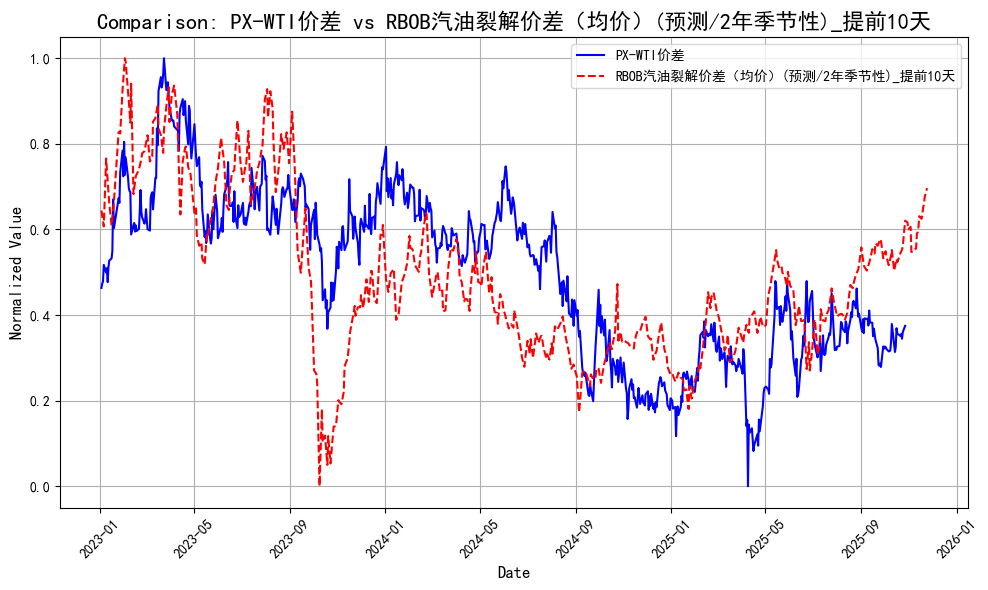

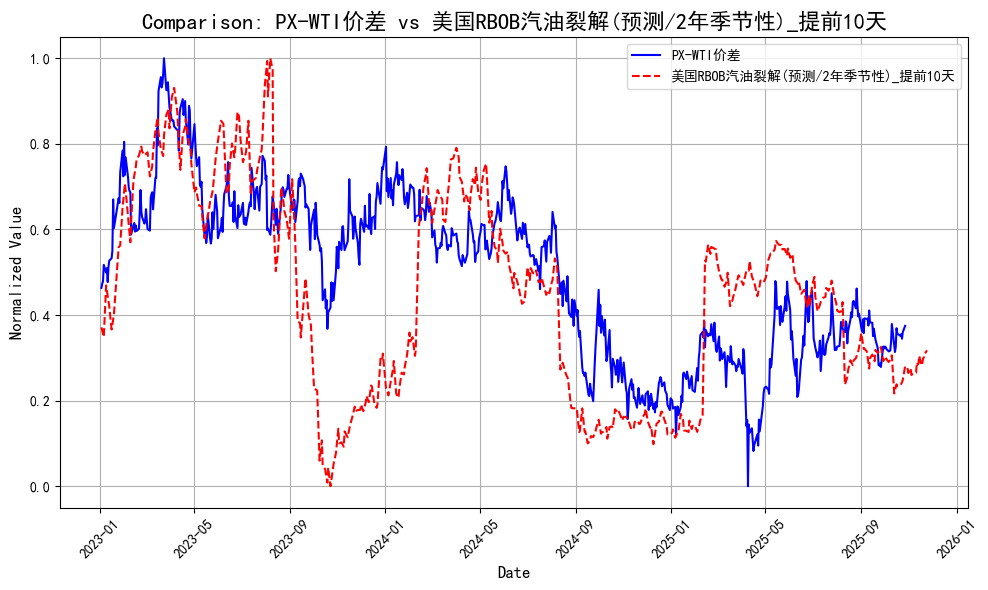

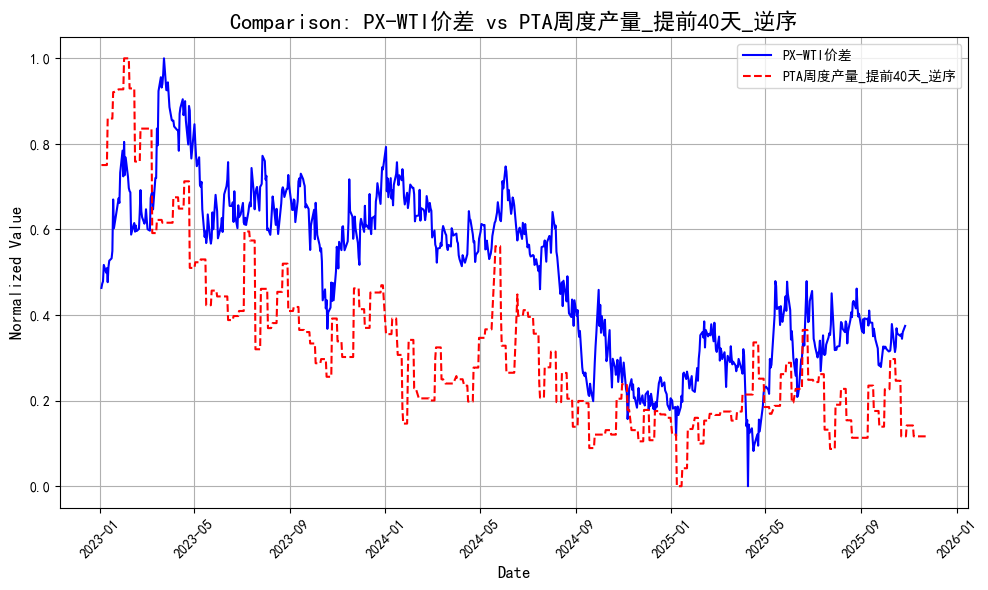

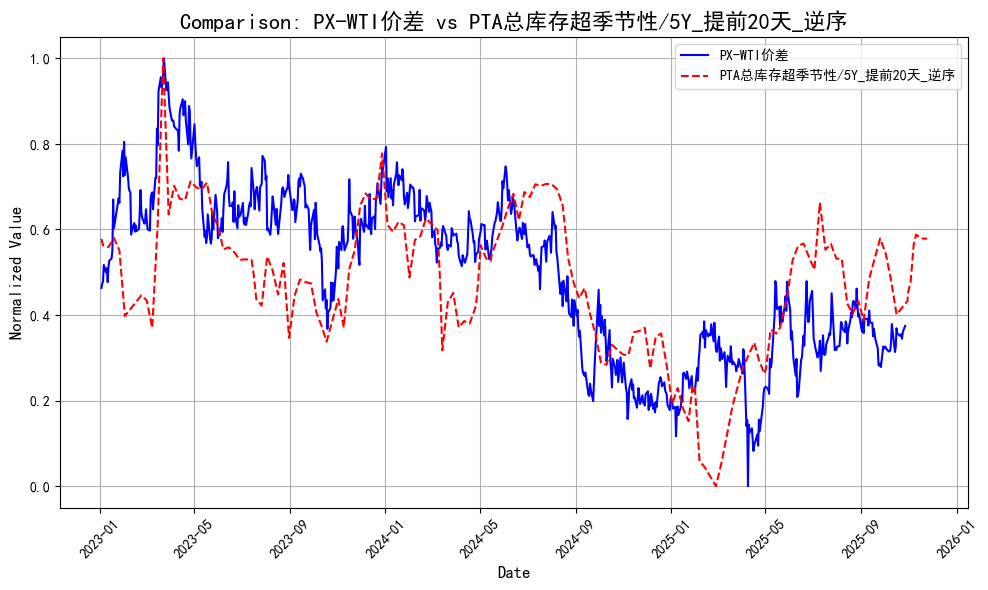

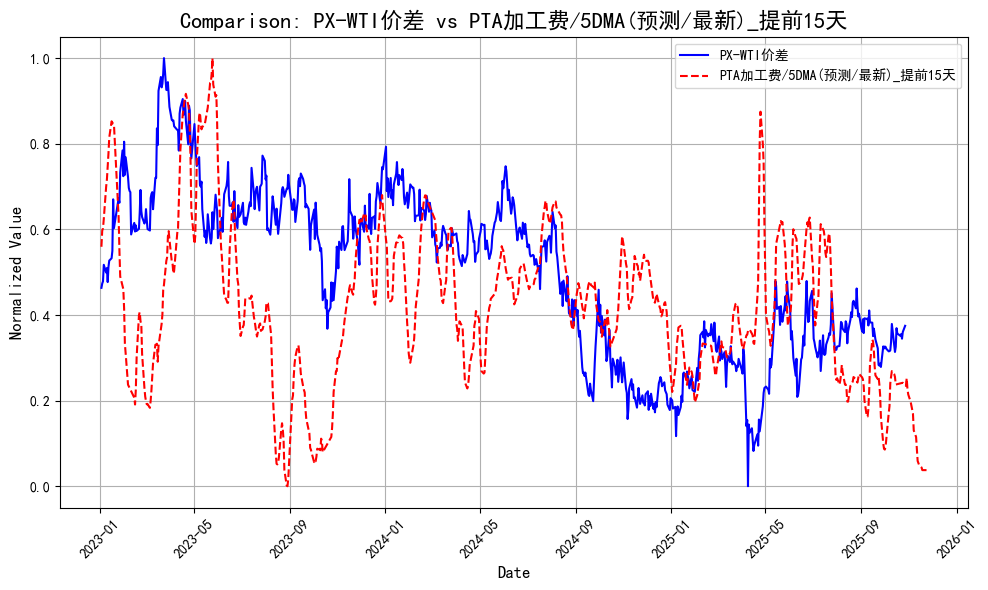

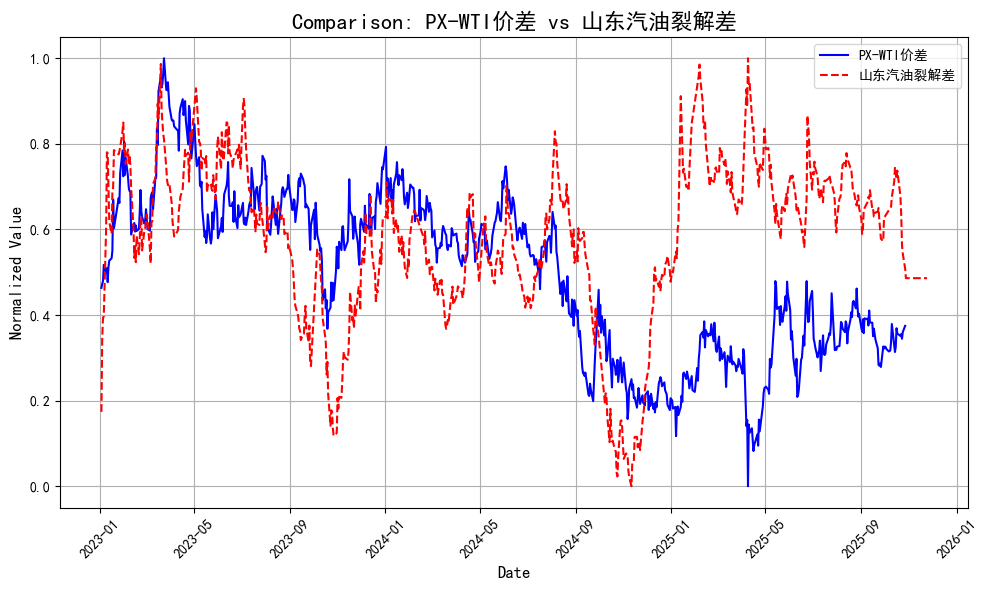

In [10]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='PX-WTI价差', 
    compare_cols=[
        'RBOB汽油裂解价差（均价）(预测/2年季节性)_提前10天',
        '美国RBOB汽油裂解(预测/2年季节性)_提前10天',
        'PTA周度产量_提前40天_逆序',
        'PTA总库存超季节性/5Y_提前20天_逆序',
        'PTA加工费/5DMA(预测/最新)_提前15天',
        '山东汽油裂解差'
        ]
)

In [11]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 30
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        'RBOB汽油裂解价差（均价）(预测/2年季节性)_提前10天',
        '美国RBOB汽油裂解(预测/2年季节性)_提前10天',
        'PTA周度产量_提前40天_逆序',
        'PTA总库存超季节性/5Y_提前20天_逆序',
        'PTA加工费/5DMA(预测/最新)_提前15天',
        '山东汽油裂解差'
]

predict_column = 'PX-WTI价差'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.06479,  # 较小的学习率
    'max_depth': 9,  # 控制树的深度防止过拟合
    'min_child_weight': 4.714,  # 控制过拟合
    'subsample': 0.6126,  # 随机采样防止过拟合
    'colsample_bytree': 0.7795,  # 特征随机采样
    'gamma': 0.07064,  # 控制分裂
    'reg_alpha': 0.01554,  # L1正则化
    'reg_lambda': 1.858,  # L2正则化
    'eval_metric': 'rmse', # 评估指标：选择“rmse”
    'seed': 42, # 随机种子
#    'max_delta_step': 5,
#    'tree_method': 'auto'
}


num_boost_round = 5000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=100 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:57.91156	train-rmse:62.36485


[100]	eval-rmse:68.49746	train-rmse:6.68954


[200]	eval-rmse:68.48314	train-rmse:3.76157


[300]	eval-rmse:68.43963	train-rmse:2.47068


[400]	eval-rmse:68.73500	train-rmse:1.78778


[500]	eval-rmse:68.72350	train-rmse:1.33218


[600]	eval-rmse:68.63085	train-rmse:1.01578


[700]	eval-rmse:68.59741	train-rmse:0.79033


[800]	eval-rmse:68.74198	train-rmse:0.63362


[900]	eval-rmse:68.70327	train-rmse:0.52149


[1000]	eval-rmse:68.71267	train-rmse:0.44750


[1100]	eval-rmse:68.72007	train-rmse:0.37740


[1200]	eval-rmse:68.71972	train-rmse:0.33123


[1300]	eval-rmse:68.71096	train-rmse:0.29866


[1400]	eval-rmse:68.69455	train-rmse:0.27297


[1500]	eval-rmse:68.69475	train-rmse:0.25654


[1600]	eval-rmse:68.69985	train-rmse:0.24042


[1700]	eval-rmse:68.69208	train-rmse:0.22653


[1800]	eval-rmse:68.69800	train-rmse:0.21468


[1900]	eval-rmse:68.69891	train-rmse:0.20611


[2000]	eval-rmse:68.69150	train-rmse:0.19928


[2100]	eval-rmse:68.69194	train-rmse:0.19354


[2200]	eval-rmse:68.70401	train-rmse:0.18902


[2300]	eval-rmse:68.70499	train-rmse:0.18706


[2400]	eval-rmse:68.70215	train-rmse:0.18382


[2500]	eval-rmse:68.70524	train-rmse:0.17989


[2600]	eval-rmse:68.70750	train-rmse:0.17731


[2700]	eval-rmse:68.69968	train-rmse:0.17547


[2800]	eval-rmse:68.70385	train-rmse:0.17382


[2900]	eval-rmse:68.70639	train-rmse:0.17108


[3000]	eval-rmse:68.69582	train-rmse:0.16941


[3100]	eval-rmse:68.70372	train-rmse:0.16836


[3200]	eval-rmse:68.70847	train-rmse:0.16683


[3300]	eval-rmse:68.70501	train-rmse:0.16578


[3400]	eval-rmse:68.70760	train-rmse:0.16479


[3500]	eval-rmse:68.71051	train-rmse:0.16351


[3600]	eval-rmse:68.70871	train-rmse:0.16240


[3700]	eval-rmse:68.70276	train-rmse:0.16160


[3800]	eval-rmse:68.70693	train-rmse:0.16105


[3900]	eval-rmse:68.71331	train-rmse:0.15985


[4000]	eval-rmse:68.71211	train-rmse:0.15917


[4100]	eval-rmse:68.71234	train-rmse:0.15864


[4200]	eval-rmse:68.72182	train-rmse:0.15812


[4300]	eval-rmse:68.71937	train-rmse:0.15748


[4400]	eval-rmse:68.71858	train-rmse:0.15658


[4500]	eval-rmse:68.71984	train-rmse:0.15599


[4600]	eval-rmse:68.71477	train-rmse:0.15546


[4700]	eval-rmse:68.71655	train-rmse:0.15475


[4800]	eval-rmse:68.72139	train-rmse:0.15435


[4900]	eval-rmse:68.71707	train-rmse:0.15399


[4999]	eval-rmse:68.71374	train-rmse:0.15344


训练集 MSE (DMatrix): 0.0257, 训练集 R² (DMatrix): 1.0
测试集 MSE (DMatrix): 4721.5779, 测试集 R² (DMatrix): -47.8537


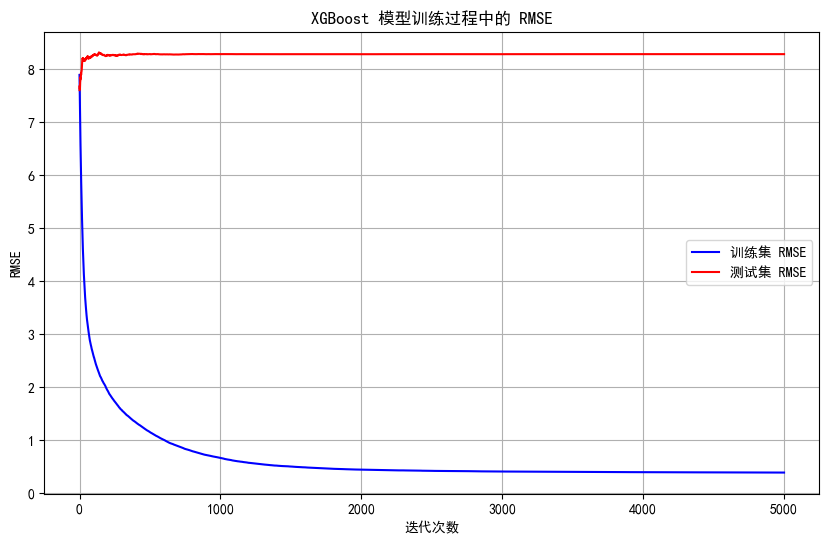

In [12]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=100
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:62.07588


[100]	train-rmse:6.78470


[200]	train-rmse:3.77045


[300]	train-rmse:2.50337


[400]	train-rmse:1.79852


[500]	train-rmse:1.35818


[600]	train-rmse:1.05751


[700]	train-rmse:0.84830


[800]	train-rmse:0.69307


[900]	train-rmse:0.58135


[1000]	train-rmse:0.50027


[1100]	train-rmse:0.43453


[1200]	train-rmse:0.37815


[1300]	train-rmse:0.33752


[1400]	train-rmse:0.30405


[1500]	train-rmse:0.27984


[1600]	train-rmse:0.26099


[1700]	train-rmse:0.24211


[1800]	train-rmse:0.22835


[1900]	train-rmse:0.21786


[2000]	train-rmse:0.20879


[2100]	train-rmse:0.20342


[2200]	train-rmse:0.19768


[2300]	train-rmse:0.19344


[2400]	train-rmse:0.18888


[2500]	train-rmse:0.18479


[2600]	train-rmse:0.18223


[2700]	train-rmse:0.18052


[2800]	train-rmse:0.17881


[2900]	train-rmse:0.17610


[3000]	train-rmse:0.17436


[3100]	train-rmse:0.17296


[3200]	train-rmse:0.17095


[3300]	train-rmse:0.16994


[3400]	train-rmse:0.16903


[3500]	train-rmse:0.16800


[3600]	train-rmse:0.16714


[3700]	train-rmse:0.16622


[3800]	train-rmse:0.16554


[3900]	train-rmse:0.16414


[4000]	train-rmse:0.16342


[4100]	train-rmse:0.16250


[4200]	train-rmse:0.16199


[4300]	train-rmse:0.16061


[4400]	train-rmse:0.16005


[4500]	train-rmse:0.15919


[4600]	train-rmse:0.15854


[4700]	train-rmse:0.15822


[4800]	train-rmse:0.15776


[4900]	train-rmse:0.15705


[4999]	train-rmse:0.15646


全部数据 MSE: 0.0263, 全部数据 R²: 1.0


Gap between last actual value and first prediction: -6.033095703125014


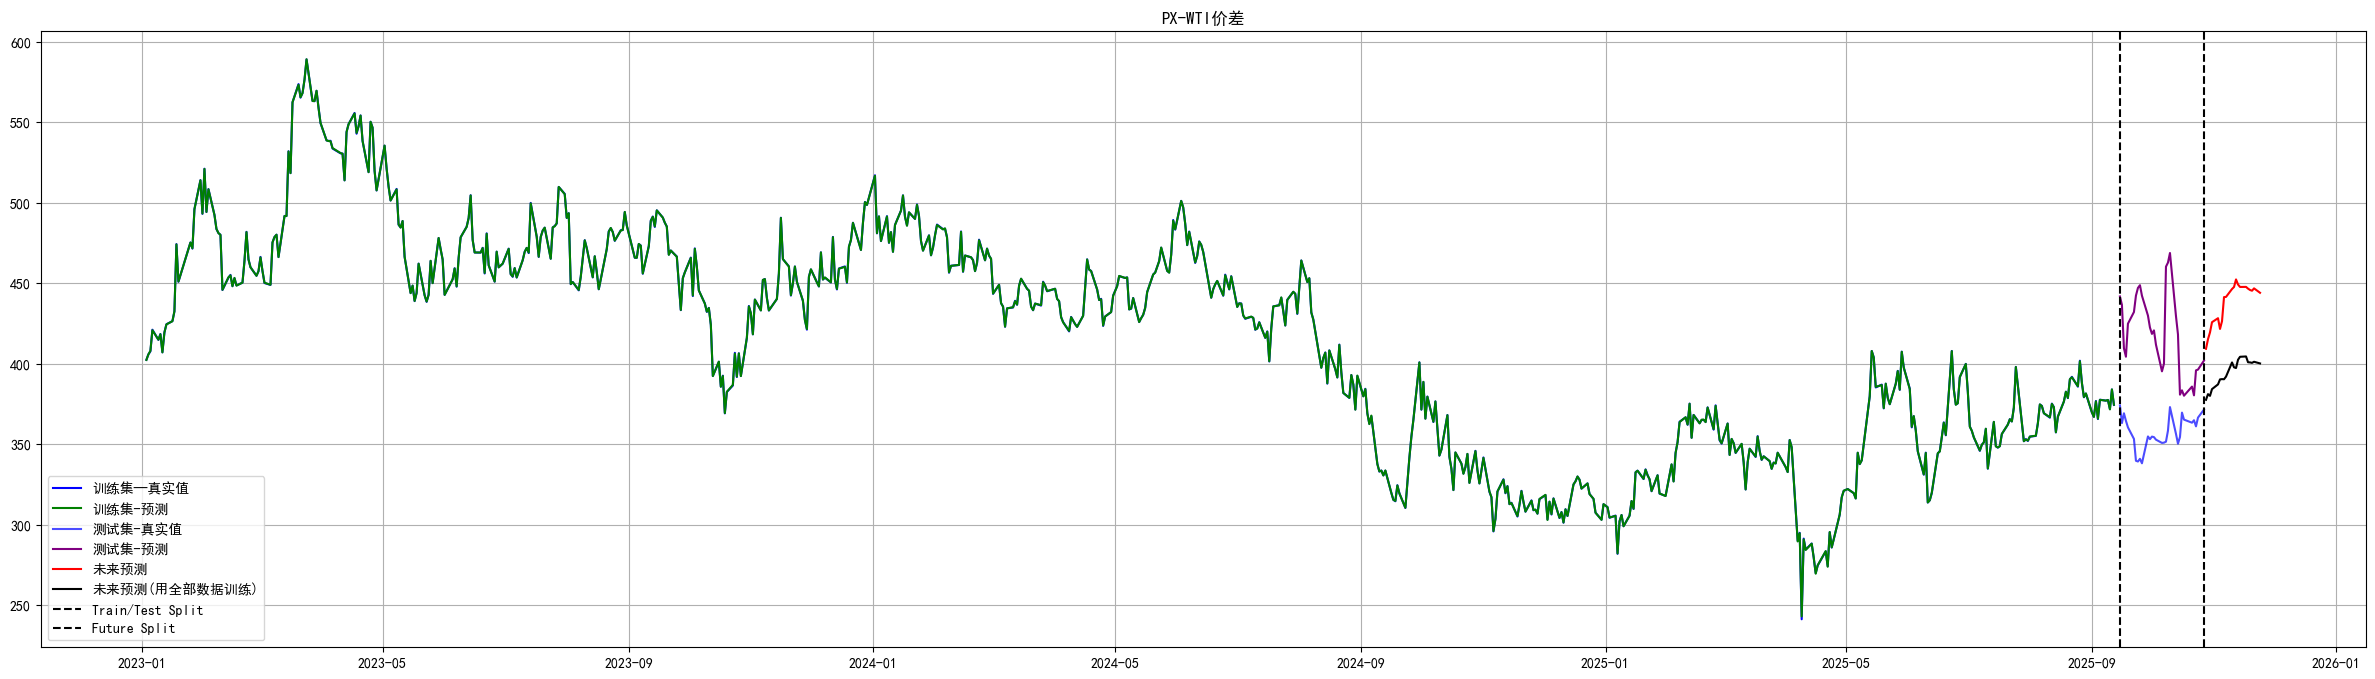

In [14]:
plt.figure(figsize=(30, 8))
# 绘制主要数据
future_data = plot_predictions(y_test, future_data, col=True, label=True)
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('PX-WTI价差')
plt.legend()
plt.grid(True)
plt.show()

---

In [15]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})


merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/PX-WTI价差_合并数据.xlsx', index=False,float_format='%.1f')

merged_df_daily

,Date,真实值,预测值
725,2025/11/24,NaN,400.144958
724,2025/11/21,NaN,401.179108
723,2025/11/20,NaN,400.505096
722,2025/11/19,NaN,400.784363
721,2025/11/18,NaN,400.883209
...,...,...,...
4,2023/01/09,414.779,NaN
3,2023/01/06,421.101,NaN
2,2023/01/05,407.641,NaN
1,2023/01/04,405.824,NaN


In [16]:
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
# 保存成excel
merged_df_monthly.to_excel('eta/PX-WTI价差_月度数据.xlsx', index=False, float_format='%.1f')
merged_df_monthly

,Date,真实值,预测值
34,2025/11/30,NaN,397.530609
33,2025/10/31,359.430167,405.133789
32,2025/09/30,363.255500,405.587585
31,2025/08/31,375.495571,375.490570
30,2025/07/31,358.478957,358.488922
29,2025/06/30,358.924048,358.935883
28,2025/05/31,371.466100,371.458801
27,2025/04/30,297.948905,297.973694
26,2025/03/31,343.621200,343.616882
25,2025/02/28,358.951000,358.950134


---

In [17]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.化工_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "PX-WTI价差"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [18]:
from Lcel import update_excel_data
file_path = "eta/1.化工_数据上传.xlsx"
sheet_name = "详情页"
identifier = "PX-WTI价差"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 23 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/10/31, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
